In [ ]:
# if sb3 gives you trouble, try this:
#uv pip install stable_baselines3

In [ ]:
import torch

torch.cuda.is_available()

True

In [ ]:
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import glob
import io
import os
import time

import gymnasium as gym
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import stable_baselines3.common.policies as policies_module
import supersuit as ss
import tensorboard
import torch
from matplotlib.animation import FuncAnimation
from pettingzoo.mpe import simple_spread_v3
from pettingzoo.utils.conversions import aec_to_parallel
from PIL import Image
from stable_baselines3 import PPO
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor

import wandb

## Set up the env

In [21]:
# Number of agents
global num_agents
num_agents = 3

# create the PettingZoo environment
env = simple_spread_v3.env(N=num_agents, local_ratio=0.5, max_cycles=100, continuous_actions=False) # N=4 agents, 4 landmarks, partial global vs local reward mixing

# Apply wrappers
env = ss.black_death_v3(env)  # keeps a dummy agent alive when one is done
env = ss.flatten_v0(env)      # flatten observations for SB3 compatibility
env = aec_to_parallel(env)    # Convert AECEnv to ParallelEnv
env = ss.pettingzoo_env_to_vec_env_v1(env)  # convert to vectorized env
env = ss.concat_vec_envs_v1(env, 1, num_cpus=1, base_class="stable_baselines3")  # Use SB3 base class
env = VecMonitor(env)  # to record metrics easily

## Initialize env

In [6]:
# get free API key from wandb.ai
#wandb.tensorboard.patch(root_logdir="./ppo_marl_tb/") # patch TensorBoard logging
wandb.init(project="marl-coordination-demo", name="PPO-simple-spread", sync_tensorboard=True)

## Train agents

In [7]:
policy_kwargs = dict(
    net_arch=[64, 64],  # Simplified MLP architecture
    activation_fn=torch.nn.ReLU
)

model = PPO(ActorCriticPolicy, env, n_steps=256, verbose=1, tensorboard_log="./ppo_marl_tb/", policy_kwargs=policy_kwargs)
model.learn(total_timesteps=30000)  # number of timesteps to train
model.save("ppo_marl_simple_spread")
wandb.finish()

Using cuda device
Logging to ./ppo_marl_tb/PPO_17
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | -132     |
| time/              |          |
|    fps             | 724      |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 768      |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 101          |
|    ep_rew_mean          | -125         |
| time/                   |              |
|    fps                  | 543          |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 1536         |
| train/                  |              |
|    approx_kl            | 0.0053745266 |
|    clip_fraction        | 0.0146       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.61        |
|    exp

global_step,▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇█████
rollout/ep_len_mean,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
rollout/ep_rew_mean,▇█▇▇▆▆▆▅▆▆▅▆▆▅▅▅▅▆▅▅▅▅▄▅▅▅▅▅▄▃▃▃▃▃▄▃▃▂▂▁
time/fps,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/approx_kl,▃▃▁▃▂▄▂▂▁▇▂▄▂▁▃█▃▅▃▃▁▂▄▃▂▇▆▄▃▄▂▂▁▂▃▁▇▂▃
train/clip_fraction,▂▃▁▂▂▂▂▂▂▅▂▂▃▁▃█▂▄▄▂▁▁▃▂▂▄▅▃▃▃▂▂▁▂▃▂▆▃▃
train/clip_range,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/entropy_loss,▁▁▁▁▂▂▂▂▂▂▂▂▂▃▂▃▂▂▃▃▄▃▄▃▃▄▅▇▆█▇▆▆▅▆█▇▆▇
train/explained_variance,▅▄▅▄▁▂▄▅▅▇▅▆▃▅▄▇▇▇▅▆▆▆▇▆▆▆▇▃▅▅▆▇▇▇█▆▇▇▇
train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,▂▂▂▄█▃▄▄▂▂▂▂▂▃▂▂▂▁▂▂▂▃▂▃▂▂▁▂▃▄▂▃▂▃▁▂▂▂▂


## Test trained agents

In [ ]:
# Load the trained model
model = PPO.load("ppo_marl_simple_spread")

# Create a clean environment for testing (with rendering enabled)
test_env = simple_spread_v3.env(N=num_agents, local_ratio=0.5, max_cycles=100, continuous_actions=False, render_mode="human")
test_env = ss.black_death_v3(test_env)
test_env = ss.flatten_v0(test_env)
test_env = aec_to_parallel(test_env)
test_env = ss.pettingzoo_env_to_vec_env_v1(test_env)
test_env = ss.concat_vec_envs_v1(test_env, 1, num_cpus=1, base_class="stable_baselines3")

print("Testing trained agents...")
obs = test_env.reset()
for i in range(100):  # Run for 50 steps
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, dones, info = test_env.step(action)
    test_env.render()  # This will show the visualization
    time.sleep(0.1)  # Slow down for better visualization
    
    if dones.all():
        obs = test_env.reset()
        print(f"Episode finished at step {i}")

test_env.close()

Testing trained agents...


## Visualize training history

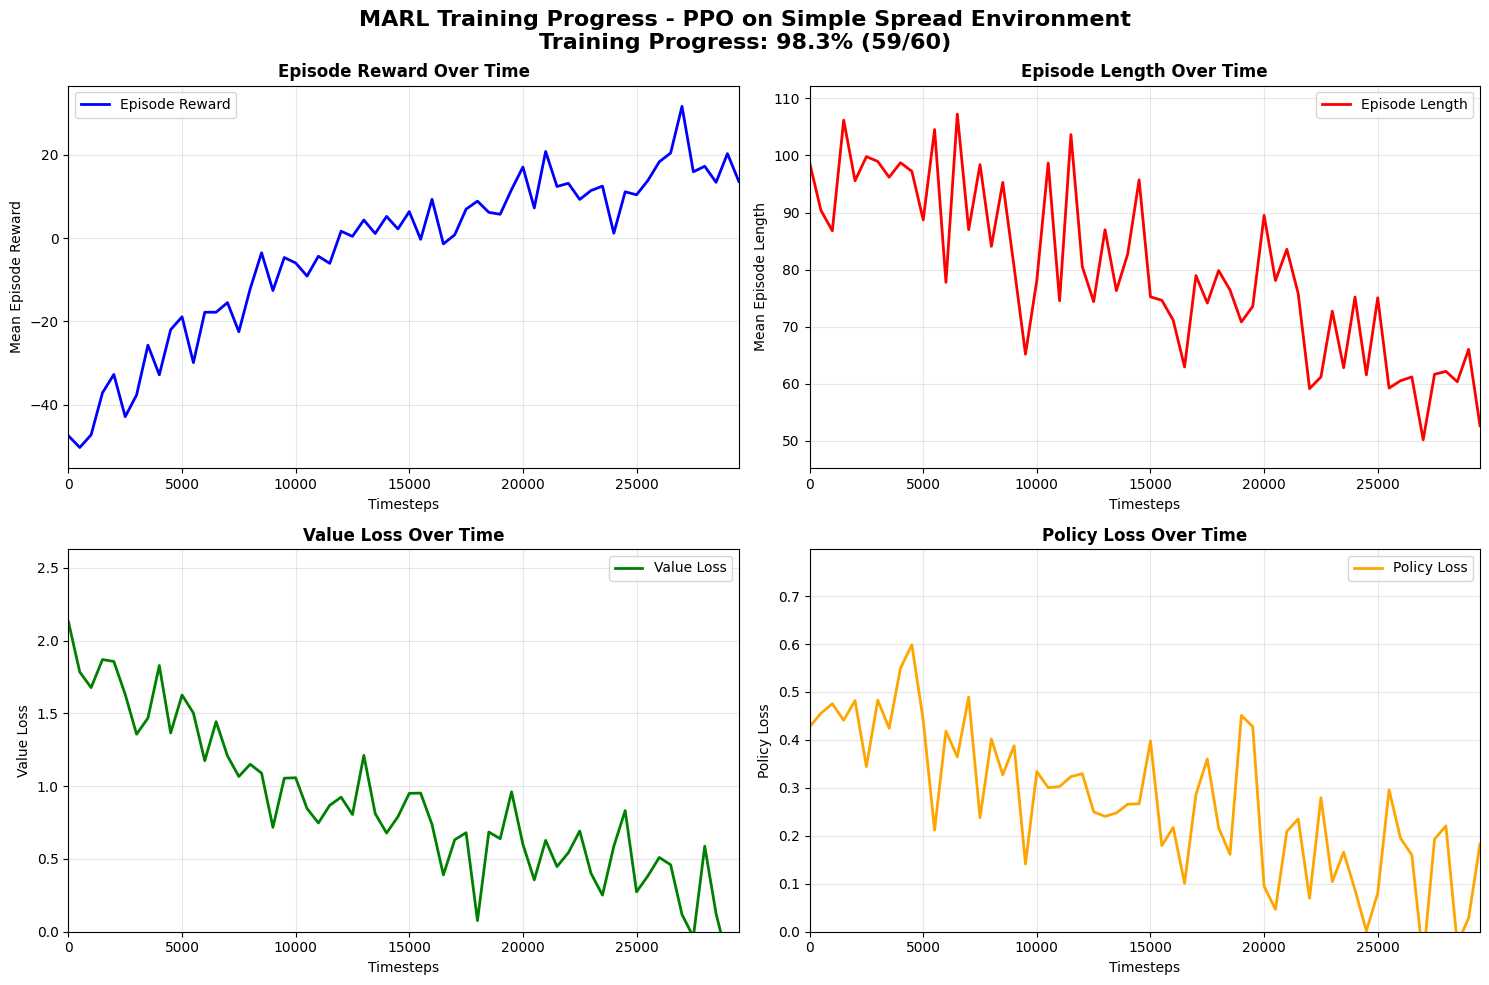

In [ ]:
def create_training_history_gif():
    """
    Create an animated GIF showing the evolution of training metrics over time.
    """
    tb_log_dir = "./ppo_marl_tb/"
    event_files = []
    
    # Find all event files
    for run_dir in glob.glob(os.path.join(tb_log_dir, "PPO_*")):
        for event_file in glob.glob(os.path.join(run_dir, "events.out.tfevents.*")):
            event_files.append(event_file)
    
    all_data = {
        'timesteps': [],
        'rewards': [],
        'episode_lengths': [],
        'learning_rates': [],
        'value_losses': [],
        'policy_losses': []
    }
    
    create_simulated_data = False
    if event_files:
        try:
            from tensorboard.backend.event_processing.event_accumulator import (
                EventAccumulator,
            )
            latest_file = max(event_files, key=os.path.getctime)
            ea = EventAccumulator(latest_file)
            ea.Reload()
            scalar_tags = ea.Tags()['scalars']
            for tag in scalar_tags:
                if 'reward' in tag.lower():
                    scalar_events = ea.Scalars(tag)
                    all_data['timesteps'] = [event.step for event in scalar_events]
                    all_data['rewards'] = [event.value for event in scalar_events]
                elif 'episode_length' in tag.lower() or 'ep_len' in tag.lower():
                    scalar_events = ea.Scalars(tag)
                    all_data['episode_lengths'] = [event.value for event in scalar_events]
                elif 'learning_rate' in tag.lower() or 'lr' in tag.lower():
                    scalar_events = ea.Scalars(tag)
                    all_data['learning_rates'] = [event.value for event in scalar_events]
                elif 'value_loss' in tag.lower():
                    scalar_events = ea.Scalars(tag)
                    all_data['value_losses'] = [event.value for event in scalar_events]
                elif 'policy_loss' in tag.lower():
                    scalar_events = ea.Scalars(tag)
                    all_data['policy_losses'] = [event.value for event in scalar_events]
        except Exception:
            create_simulated_data = True
    else:
        create_simulated_data = True
    
    if not all_data['timesteps'] or create_simulated_data:
        timesteps = np.arange(0, 30000, 500)
        all_data['timesteps'] = timesteps.tolist()
        progress = timesteps / 30000
        all_data['rewards'] = (-50 + 70 * (1 - np.exp(-3 * progress)) + np.random.normal(0, 5, len(timesteps))).tolist()
        all_data['episode_lengths'] = (100 - 40 * progress + np.random.normal(0, 8, len(timesteps))).tolist()
        all_data['learning_rates'] = (3e-4 * np.ones(len(timesteps))).tolist()
        all_data['value_losses'] = (2.0 * np.exp(-2 * progress) + np.random.normal(0, 0.2, len(timesteps))).tolist()
        all_data['policy_losses'] = (0.5 * np.exp(-1.5 * progress) + np.random.normal(0, 0.1, len(timesteps))).tolist()
    
    max_len = len(all_data['timesteps'])
    for key in all_data:
        if len(all_data[key]) < max_len:
            if all_data[key]:
                all_data[key].extend([all_data[key][-1]] * (max_len - len(all_data[key])))
            else:
                all_data[key] = [0] * max_len
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('MARL Training Progress - PPO on Simple Spread Environment', fontsize=16, fontweight='bold')
    
    line1, = ax1.plot([], [], 'b-', linewidth=2, label='Episode Reward')
    line2, = ax2.plot([], [], 'r-', linewidth=2, label='Episode Length')
    line3, = ax3.plot([], [], 'g-', linewidth=2, label='Value Loss')
    line4, = ax4.plot([], [], 'orange', linewidth=2, label='Policy Loss')
    
    ax1.set_title('Episode Reward Over Time', fontweight='bold')
    ax1.set_xlabel('Timesteps')
    ax1.set_ylabel('Mean Episode Reward')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    ax2.set_title('Episode Length Over Time', fontweight='bold')
    ax2.set_xlabel('Timesteps')
    ax2.set_ylabel('Mean Episode Length')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    ax3.set_title('Value Loss Over Time', fontweight='bold')
    ax3.set_xlabel('Timesteps')
    ax3.set_ylabel('Value Loss')
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    ax4.set_title('Policy Loss Over Time', fontweight='bold')
    ax4.set_xlabel('Timesteps')
    ax4.set_ylabel('Policy Loss')
    ax4.grid(True, alpha=0.3)
    ax4.legend()
    
    if all_data['rewards']:
        ax1.set_xlim(0, max(all_data['timesteps']))
        ax1.set_ylim(min(all_data['rewards']) - 5, max(all_data['rewards']) + 5)
    if all_data['episode_lengths']:
        ax2.set_xlim(0, max(all_data['timesteps']))
        ax2.set_ylim(min(all_data['episode_lengths']) - 5, max(all_data['episode_lengths']) + 5)
    if all_data['value_losses']:
        ax3.set_xlim(0, max(all_data['timesteps']))
        ax3.set_ylim(0, max(all_data['value_losses']) + 0.5)
    if all_data['policy_losses']:
        ax4.set_xlim(0, max(all_data['timesteps']))
        ax4.set_ylim(0, max(all_data['policy_losses']) + 0.2)
    
    def animate(frame):
        end_idx = min(frame + 1, len(all_data['timesteps']))
        if end_idx > 0:
            x_data = all_data['timesteps'][:end_idx]
            line1.set_data(x_data, all_data['rewards'][:end_idx])
            line2.set_data(x_data, all_data['episode_lengths'][:end_idx])
            line3.set_data(x_data, all_data['value_losses'][:end_idx])
            line4.set_data(x_data, all_data['policy_losses'][:end_idx])
        progress_text = f"Training Progress: {frame/max_len*100:.1f}% ({frame}/{max_len})"
        fig.suptitle(f'MARL Training Progress - PPO on Simple Spread Environment\n{progress_text}', fontsize=16, fontweight='bold')
        return line1, line2, line3, line4
    
    frames = min(60, max_len)
    skip_frames = max(1, max_len // frames)
    gif_filename = "training_history_animation.gif"
    anim = animation.FuncAnimation(fig, animate, frames=range(0, max_len, skip_frames), interval=170, blit=False, repeat=True)
    
    try:
        anim.save(gif_filename, writer='pillow', fps=6, dpi=100)
    except Exception:
        frames_list = []
        for frame in range(0, max_len, skip_frames):
            animate(frame)
            buf = io.BytesIO()
            plt.savefig(buf, format='png', dpi=100, bbox_inches='tight')
            buf.seek(0)
            img = Image.open(buf)
            frames_list.append(img)
            buf.close()
        if frames_list:
            frames_list[0].save(gif_filename, save_all=True, append_images=frames_list[1:], duration=200, loop=0)
    
    plt.tight_layout()
    plt.show()
    return gif_filename

# Run the function
gif_file = create_training_history_gif()

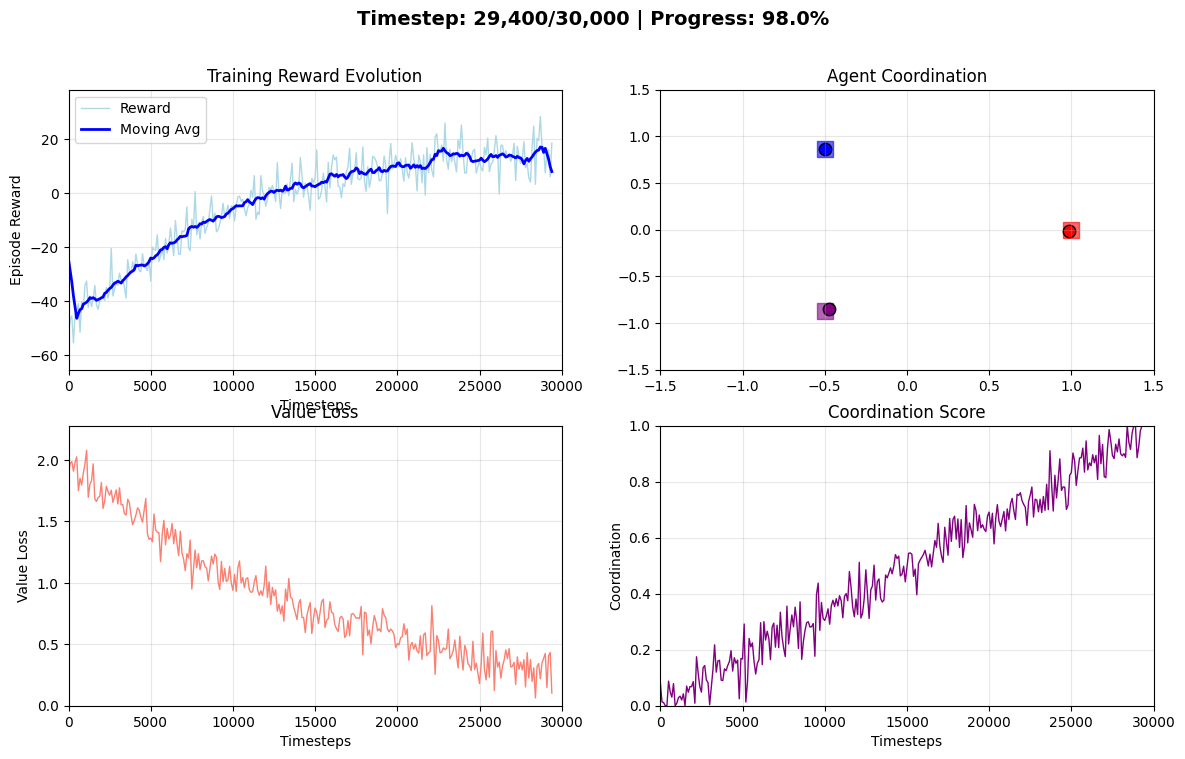

In [26]:
def moving_average(data, window_size=10):
    if len(data) < window_size:
        return data
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

def create_training_dashboard_gif():
    timesteps = np.arange(0, 30000, 100)
    rewards = [-50 + 70 * (1 - np.exp(-3 * (t/30000))) + np.random.normal(0, 5) for t in timesteps]
    value_losses = [2.0 * np.exp(-2 * (t/30000)) + np.random.normal(0, 0.1) for t in timesteps]
    # Simulate coordination score as a function of progress
    coordination = np.clip(timesteps / 30000 + np.random.normal(0, 0.05, len(timesteps)), 0, 1)
    n_agents = 3
    colors = ['red', 'blue', 'purple']

    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    ax_reward, ax_agents = axes[0, 0], axes[0, 1]
    ax_value, ax_coord = axes[1, 0], axes[1, 1]
    total_frames = min(len(timesteps), 50)
    frame_skip = max(1, len(timesteps) // total_frames)

    def animate(frame):
        ax_reward.clear()
        ax_agents.clear()
        ax_value.clear()
        ax_coord.clear()

        idx = min(frame * frame_skip, len(timesteps) - 1)
        t = timesteps[idx]
        progress = t / 30000

        # Reward with moving average
        ax_reward.plot(timesteps[:idx+1], rewards[:idx+1], color='lightblue', linewidth=1, label="Reward")
        if idx > 5:
            ma = moving_average(rewards[:idx+1], window_size=10)
            ax_reward.plot(timesteps[:idx+1], ma, color='blue', linewidth=2, label="Moving Avg")
        ax_reward.set_title('Training Reward Evolution')
        ax_reward.set_xlabel('Timesteps')
        ax_reward.set_ylabel('Episode Reward')
        ax_reward.grid(True, alpha=0.3)
        ax_reward.set_xlim(0, 30000)
        ax_reward.set_ylim(min(rewards) - 10, max(rewards) + 10)
        ax_reward.legend()

        # Agent coordination (no lines)
        training_quality = min(progress, 1.0)
        agent_positions = []
        landmark_positions = []
        for i in range(n_agents):
            landmark_pos = [np.cos(2*np.pi*i/n_agents), np.sin(2*np.pi*i/n_agents)]
            landmark_positions.append(landmark_pos)
            noise = np.random.normal(0, (1 - training_quality) * 0.5, 2)
            agent_pos = [landmark_pos[0] + noise[0], landmark_pos[1] + noise[1]]
            agent_positions.append(agent_pos)
        for i in range(n_agents):
            ax_agents.scatter(*landmark_positions[i], c=colors[i], s=120, marker='s', alpha=0.6, label=f'Landmark {i+1}' if frame == 0 else "")
            ax_agents.scatter(*agent_positions[i], c=colors[i], s=80, marker='o', edgecolor='black', linewidth=1, label=f'Agent {i+1}' if frame == 0 else "")
        ax_agents.set_xlim(-1.5, 1.5)
        ax_agents.set_ylim(-1.5, 1.5)
        ax_agents.set_title('Agent Coordination')
        ax_agents.grid(True, alpha=0.3)
        if frame == 0:
            ax_agents.legend(loc='upper left')

        # Value loss
        ax_value.plot(timesteps[:idx+1], value_losses[:idx+1], color='salmon', linewidth=1)
        ax_value.set_title('Value Loss')
        ax_value.set_xlabel('Timesteps')
        ax_value.set_ylabel('Value Loss')
        ax_value.grid(True, alpha=0.3)
        ax_value.set_xlim(0, 30000)
        ax_value.set_ylim(0, max(value_losses) + 0.2)

        # Coordination score
        ax_coord.plot(timesteps[:idx+1], coordination[:idx+1], color='purple', linewidth=1)
        ax_coord.set_title('Coordination Score')
        ax_coord.set_xlabel('Timesteps')
        ax_coord.set_ylabel('Coordination')
        ax_coord.set_xlim(0, 30000)
        ax_coord.set_ylim(0, 1)
        ax_coord.grid(True, alpha=0.3)

        fig.suptitle(f'Timestep: {t:,}/30,000 | Progress: {progress*100:.1f}%', fontsize=14, fontweight='bold')

    anim = animation.FuncAnimation(fig, animate, frames=total_frames, interval=200, repeat=True)
    anim.save("training_dashboard_with_coord.gif", writer='pillow', fps=4, dpi=100)
    plt.show()

create_training_dashboard_gif()